In [3]:
root_dir = '/data/ChaochaoData/DSA-DL/HyperMorph/'
workspace = root_dir + 'Comparison/'
util_dir = '/data/ChaochaoData/DSA-DL/Utilities/'
train_dir = '/data/ChaochaoData/PixShift/DataSets/PaperData/CombinedTrain'
test_dir = '/data/ChaochaoData/PixShift/DataSets/PaperData/CombinedTest'
cm_train_dir = '/data/ChaochaoData/ClearMatch/nifti_predictions/train_dataset'
cm_test_dir = '/data/ChaochaoData/ClearMatch/nifti_predictions/test_dataset'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
# plt.rcParams['animation.ffmpeg_path'] = '/usr/local/lib/python3.8/dist-packages'
import matplotlib.cm as cm
from matplotlib.colors import Normalize

import neurite as ne
import voxelmorph as vxm
import tensorflow as tf

import os, sys, shutil
import nibabel as nib
import cv2
# from scipy import ndimage
# from IPython import display  # Would conflict with Python's display
import IPython
import logging
import warnings

sys.path.insert(0, util_dir)
from utils import *
# from paper_visualization import *

warnings.filterwarnings('ignore')
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.experimental.output_all_intermediates(True)
tf.compat.v1.disable_eager_execution()
# tf.compat.v1.enable_eager_execution()

2024-01-06 00:12:18.095814: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Loading BokehJS ...

In [17]:
folders_train_old = [os.path.join(train_dir, f) for f in sorted(os.listdir(train_dir))
                     if not os.path.isfile(os.path.join(train_dir, f))]
folders_test_old = [os.path.join(test_dir, f) for f in sorted(os.listdir(test_dir))
                    if not os.path.isfile(os.path.join(test_dir, f))]
print(len(folders_train_old), len(folders_test_old))

folders_train_cm = [os.path.join(cm_train_dir, f) for f in sorted(os.listdir(cm_train_dir))
                    if not os.path.isfile(os.path.join(cm_train_dir, f))]
folders_test_cm = [os.path.join(cm_test_dir, f) for f in sorted(os.listdir(cm_test_dir))
                   if not os.path.isfile(os.path.join(cm_test_dir, f))]
print(len(folders_train_cm), len(folders_test_cm))

folders_train = folders_train_old + folders_train_cm
folders_test = folders_test_old + folders_test_cm

print(len(folders_train), len(folders_test))

folders_sel = folders_testfolders_train_old = [os.path.join(train_dir, f) for f in sorted(os.listdir(train_dir))
                     if not os.path.isfile(os.path.join(train_dir, f))]
folders_test_old = [os.path.join(test_dir, f) for f in sorted(os.listdir(test_dir))
                    if not os.path.isfile(os.path.join(test_dir, f))]
print(len(folders_train_old), len(folders_test_old))

folders_train_cm = [os.path.join(cm_train_dir, f) for f in sorted(os.listdir(cm_train_dir))
                    if not os.path.isfile(os.path.join(cm_train_dir, f))]
folders_test_cm = [os.path.join(cm_test_dir, f) for f in sorted(os.listdir(cm_test_dir))
                   if not os.path.isfile(os.path.join(cm_test_dir, f))]
print(len(folders_train_cm), len(folders_test_cm))

folders_train = folders_train_old + folders_train_cm
folders_test = folders_test_old + folders_test_cm

print(len(folders_train), len(folders_test))

folders_sel = folders_test

4946 100
100 94
5046 194
4946 100
100 94
5046 194


In [18]:
image_shape = (512, 512)

def init_hpnet(hp_input):
    x = tf.keras.layers.Dense(32, activation='relu')(hp_input)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    hypernetwork = tf.keras.Model(hp_input, x, name='hypernetwork')
    return hypernetwork

def load_model(model_name):
    if model_name is 'Naive':
        hp_input = tf.keras.Input(shape=[1])
        hypernetwork = init_hpnet(hp_input)
        model = vxm.networks.VxmDense(image_shape, int_steps=0, hyp_model=hypernetwork)
        model_path = os.path.join(root_dir, 'Naive/dsa-hyper-naive.h5')
        model.load_weights(model_path)    
    elif model_name is 'MinMax':
        hp_input = tf.keras.Input(shape=[1])
        hypernetwork = init_hpnet(hp_input)
        model = vxm.networks.VxmDense(image_shape, int_steps=0, bidir=True, hyp_model=hypernetwork)
        model_path = os.path.join(root_dir, 'MinMax/dsa_hyper_cycle.h5')
        model.load_weights(model_path)
    elif model_name is 'FilMask':
        hp_input = tf.keras.Input(shape=[1])
        hypernetwork = init_hpnet(hp_input)
        model = vxm.networks.VxmDense(image_shape, int_steps=0, hyp_model=hypernetwork)
        model_path = os.path.join(root_dir, 'LayerSep-filter/dsa-hyper-ls.h5')
        model.load_weights(model_path)        
    # print(os.path.exists(model_path))
    return model

In [36]:
def matching(image, matchImage):
    """
    Adjust "image" to match "matchImage"
    The shape of both images: (N, H, W), where H = W 
    """
    
    ## Take the center of the frame to avoid issues with collumnation
    offs = 0  # Now, no offset is applied
    lb = 0+offs
    ub = image.shape[-1]-offs
    
    firstFrameMean = np.mean(image[0,lb:ub,lb:ub])
    firstFrameMeanMatch = np.mean(matchImage[0,lb:ub,lb:ub]) 
    
    image_centered = image - firstFrameMean
    matchImage_centered = matchImage-firstFrameMeanMatch
    
    ratio_std = np.std(matchImage_centered[:,lb:ub,lb:ub]) / np.std(image_centered[:,lb:ub,lb:ub])
    image_new = image_centered * ratio_std
    image_new = image_new + firstFrameMeanMatch
    
    maximum = np.amax(matchImage)
    minimum = np.amin(matchImage)
    image_new[image_new > maximum] = maximum
    image_new[image_new < minimum] = minimum
    return image_new

In [54]:
def gen_dsa_lambdas(model, folders, i_seq, 
                    lambdas=np.array(np.linspace(0.1, 0.9, 5))[..., None], 
                    idx_bg=0, idx_ct=None):
    
    xrays = load_xray_seq(folders=folders, i_seq=i_seq)
    
    image_bg = xrays[idx_bg][None, ...]
    
    if idx_ct is None:
        image_ct = xrays[len(xrays)//2][None, ...]
    else:
        image_ct = xrays[idx_ct][None, ...]

    if lambdas is None:
        lambdas = np.array(np.linspace(0.1, 0.9, 5))[...,None]
                       
    Ndisp = len(lambdas)
    images_moving = np.repeat(image_bg, Ndisp, axis=0)
    images_fixed = np.repeat(image_ct, Ndisp, axis=0)
  
    preds = model.predict([images_moving, images_fixed, lambdas], verbose=0)
    images_pred = preds[0]
    warps_pred = preds[-1]

    dsa_org = images_fixed - images_moving
    dsa_pred = images_fixed - images_pred

    dsa_org = (dsa_org - dsa_org.min()) / (dsa_org.max() - dsa_org.min())
    dsa_pred = (dsa_pred - dsa_pred.min()) / (dsa_pred.max() - dsa_pred.min())
    #dsa_pred = matching(image=dsa_pred[...,0], matchImage=dsa_org[...,0])

    return dsa_org, dsa_pred, warps_pred, lambdas

In [70]:
def disp_dsa_lambdas(dsa_org, dsa_pred, warps_pred, lambdas, sub_width=3):
    Ndisp = len(dsa_org)
    
    # fig, axes = plt.subplots(1, Ndisp, figsize=(Ndisp*3,4), constrained_layout=True)
    fig, axes = plt.subplots(1, Ndisp, figsize=(Ndisp*sub_width, sub_width))
    for i in range(Ndisp):
        axes[i].imshow(dsa_org[i], cmap='gray', vmin=np.min(dsa_org), vmax=np.max(dsa_org))
        axes[i].axis('off')
        #axes[i].set_title('frm: {}'.format(indices[i]))
    plt.tight_layout()
    plt.show()

    # fig, axes = plt.subplots(1, Ndisp, figsize=(Ndisp*3,4), constrained_layout=True)
    fig, axes = plt.subplots(1, Ndisp, figsize=(Ndisp*sub_width, sub_width))
    for i in range(Ndisp):
        axes[i].imshow(dsa_pred[i], cmap='gray', vmin=np.min(dsa_pred), vmax=np.max(dsa_pred))
        axes[i].axis('off')
        axes[i].set_title('λ: {:.2f}'.format(lambdas[i,0]), fontsize=20)
    plt.tight_layout()
    plt.show()

    flows = [warp[::6,::6,:] for warp in warps_pred]
    ne.plot.flow(flows, width=Ndisp*sub_width);

In [29]:
models = {
    'Naive': load_model('Naive'),
    'MinMax': load_model('MinMax'),
    'FilMask': load_model('FilMask')
}

2024-01-06 00:39:07.844427: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 00:39:10.355093: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2024-01-06 00:39:10.355854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 40675 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6
2024-01-06 00:39:10.447048: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [195]:
i_seq = 7  # 1, 7, 9, 26
dsa_org, dsa_pred1, warps_pred1, lambdas = gen_dsa_lambdas(model=models['Naive'], folders=folders_test, i_seq=i_seq)
_, dsa_pred2, warps_pred2, _ = gen_dsa_lambdas(model=models['MinMax'], folders=folders_test, i_seq=i_seq)
_, dsa_pred3, warps_pred3, _ = gen_dsa_lambdas(model=models['FilMask'], folders=folders_test, i_seq=i_seq)

# dsa_ref = np.mean([dsa_pred1, dsa_pred2, dsa_pred3], axis=0)
dsa_ref = dsa_pred3
dsa_org = matching(image=dsa_org[...,0], matchImage=dsa_ref[...,0])
dsa_pred1 = matching(image=dsa_pred1[...,0], matchImage=dsa_ref[...,0])
dsa_pred2 = matching(image=dsa_pred2[...,0], matchImage=dsa_ref[...,0])
dsa_pred3 = matching(image=dsa_pred3[...,0], matchImage=dsa_ref[...,0])

# disp_dsa_lambdas(dsa_org, dsa_pred1, warps_pred1, lambdas)
# disp_dsa_lambdas(dsa_org, dsa_pred2, warps_pred2, lambdas)
# disp_dsa_lambdas(dsa_org, dsa_pred3, warps_pred3, lambdas)

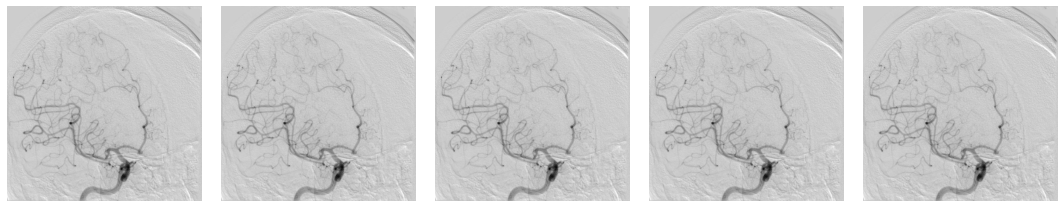

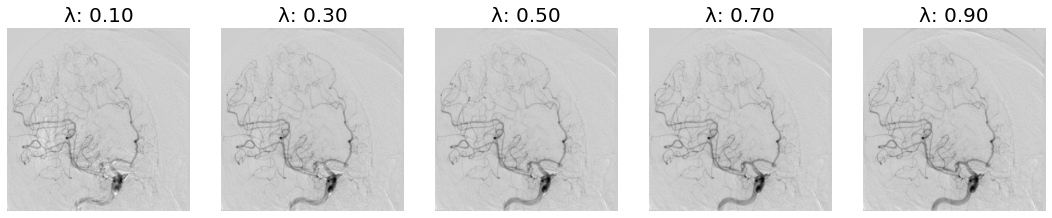

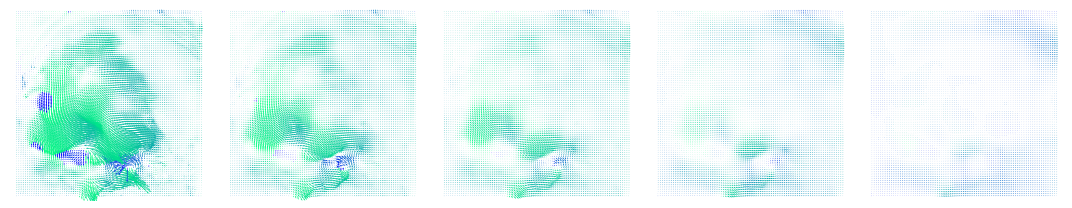

In [196]:
disp_dsa_lambdas(dsa_org, dsa_pred1, warps_pred1, lambdas)

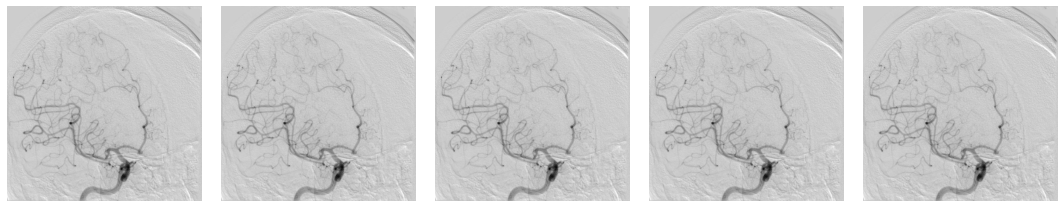

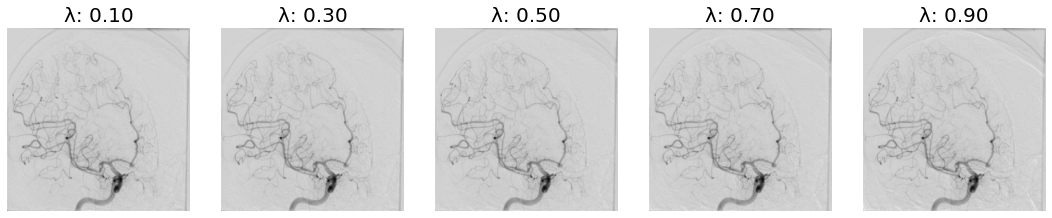

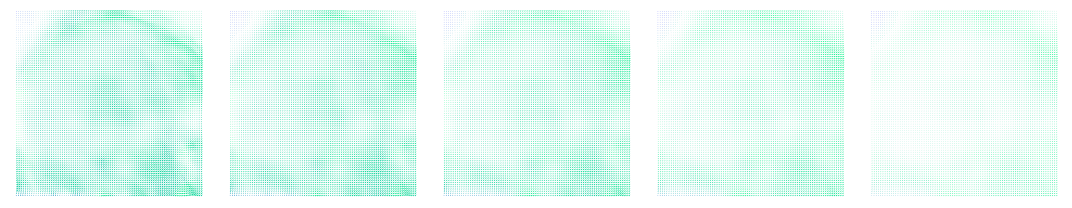

In [197]:
disp_dsa_lambdas(dsa_org, dsa_pred2, warps_pred2, lambdas)

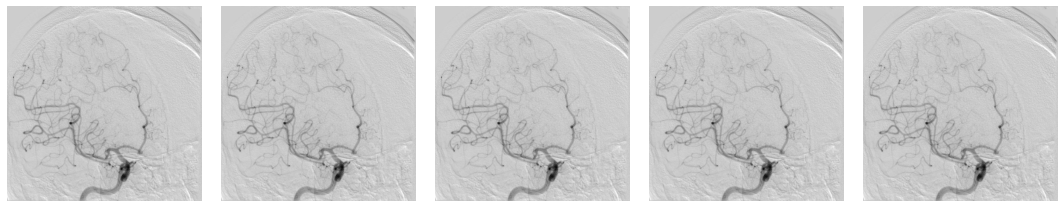

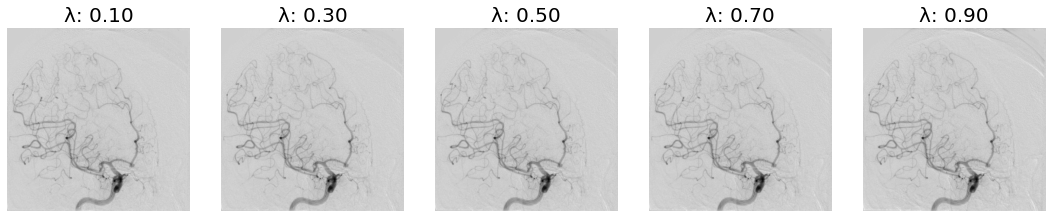

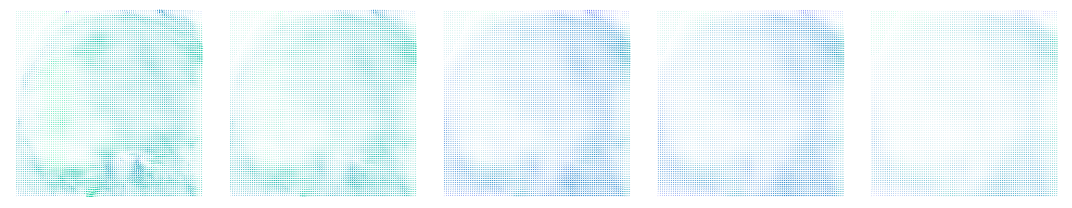

In [198]:
disp_dsa_lambdas(dsa_org, dsa_pred3, warps_pred3, lambdas)